In [12]:
include("../src/HPFEM.jl")

HPFEM

In [13]:
nel = 10
nnodes = nel + 1
idir = [1,nnodes]
M = 15
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [14]:
fun(x) = x
resp(x) = airyai(x)
λ(x) = x

λ (generic function with 1 method)

In [15]:
a = -1
b = 1
nodes = collect(linspace(a, b, nnodes))

11-element Array{Float64,1}:
 -1.0
 -0.8
 -0.6
 -0.4
 -0.2
  0.0
  0.2
  0.4
  0.6
  0.8
  1.0

In [16]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [17]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix);

In [18]:
for e = 1:nel
    x  = elems[e].x
    lambda = λ(x)
    Ae = HPFEM.mass_matrix(bas, elems[e],lambda)
    Se = HPFEM.stiff_matrix(bas,elems[e])
    Ae = Ae + Se
    HPFEM.add_local_matrix(solver, e, Ae)
end


LoadError: LoadError: MethodError: `*` has no method matching *(::Float64, ::Type{AbstractArray{Float64,1}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
  *(::Float64, !Matched::Float64)
  *(::Real, !Matched::Complex{Bool})
  ...
while loading In[18], in expression starting on line 1

In [19]:
Fe = zeros(HPFEM.nmodes(lmap), nel)
for e = 1:nel
    fe = fun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
#Fe[1,1] = airyai(a)
#Fe[2,nel]= airyai(b)


In [20]:
HPFEM.solve!(solver, Fe)

LoadError: LoadError: KeyError: 1 not found
while loading In[20], in expression starting on line 1

In [21]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;



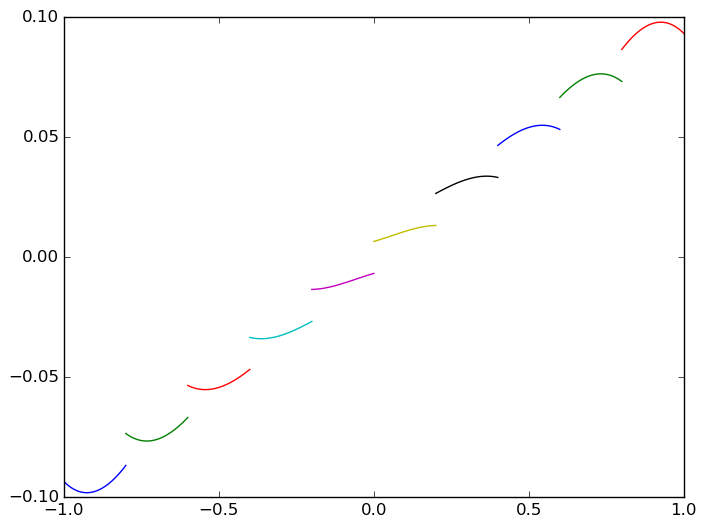

0.631939666483623

In [22]:
using PyPlot
x = [(1-ξ)*el.a/2 + (1+ξ)*el.b/2 for el in elems]
maxerr = 0.0

for e = 1:nel
    uu = resp(x[e])
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
    plot(x[e], Ue[:,e])
    #plot(x[e], uu, "b")
end
maxerr